### Autoregressive Models

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim
import time
import torch.utils.data
# display routines
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

embedding = 4 # embedding dimension for autoregressive model
T = 1000      # generate a total of 1000 points 
time = torch.arange(0.0,T)
x = torch.sin(0.01 * time) + 0.2 * torch.randn(T)

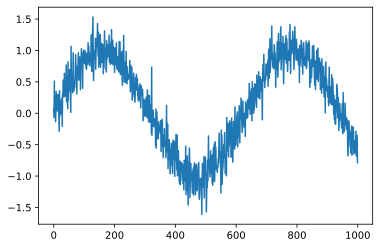

In [2]:
plt.plot(time.numpy(), x.numpy());

### Generating the Regression Dataset

In [3]:
features = torch.zeros((T-embedding, embedding))
for i in range(embedding):
    features[:,i] = x[i:T-embedding+i]
labels = x[embedding:]

ntrain = 600
train_data = torch.utils.data.TensorDataset(features[:ntrain,:], labels[:ntrain])
test_data  = torch.utils.data.TensorDataset(features[ntrain:,:], labels[ntrain:])

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)

def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    return net

loss = nn.MSELoss()

### Training

In [4]:
# simple optimizer using adam, random shuffle and minibatch size 16
def train_net(net, data, loss, epochs, learningrate):
    batch_size = 16
    trainer = optim.Adam(net.parameters(), lr = learningrate)
    data_iter = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)
    for epoch in range(1, epochs + 1):
        net.train()
        for X, y in data_iter:
            trainer.zero_grad()
            l = loss(net(X), y.reshape(-1,1))
            l.backward()
            trainer.step()
        net.eval()
        l = loss(net(data[:][0]), data[:][1].reshape(-1,1))
        print('epoch %d, loss: %f' % (epoch, l.mean().item()))
    return net

In [5]:
net = get_net()
net = train_net(net, train_data, loss, 10, 0.01)

l = loss(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
print('test loss: %f' % l.mean().item()) 

epoch 1, loss: 0.059228
epoch 2, loss: 0.055943
epoch 3, loss: 0.051811
epoch 4, loss: 0.051886
epoch 5, loss: 0.053304
epoch 6, loss: 0.052007
epoch 7, loss: 0.053710
epoch 8, loss: 0.052390
epoch 9, loss: 0.052930
epoch 10, loss: 0.051027
test loss: 0.045294


### Results

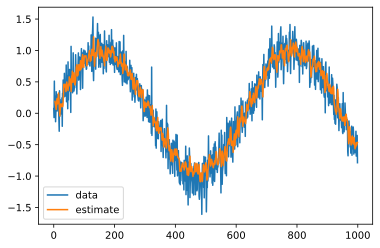

In [6]:
estimates = net(features)
plt.plot(time.numpy(), x.numpy(), label='data');
plt.plot(time[embedding:].numpy(), estimates.detach().numpy(), label='estimate');
plt.legend();

## Predictions for more than 1 step

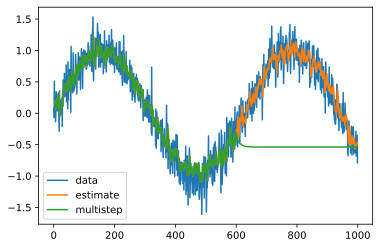

In [7]:
predictions = torch.zeros_like(estimates)
predictions[:(ntrain-embedding)] = estimates[:(ntrain-embedding)]
for i in range(ntrain-embedding, T-embedding):
    predictions[i] = net(predictions[(i-embedding):i].reshape(1,-1)).reshape(1)
    
plt.plot(time.numpy(), x.numpy(), label='data');
plt.plot(time[embedding:].numpy(), estimates.detach().numpy(), label='estimate');
plt.plot(time[embedding:].numpy(), predictions.detach().numpy(), label='multistep');
plt.legend();

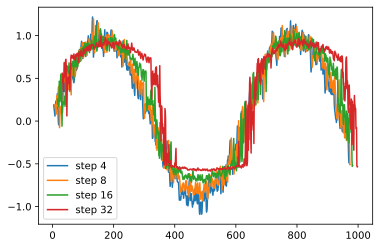

In [8]:
k = 33 # look up to k - embedding steps ahead
features = torch.zeros((T-k, k))
for i in range(embedding):
    features[:,i] = x[i:T-k+i]
for i in range(embedding, k):
    features[:,i] = net(features[:,(i-embedding):i]).reshape((-1))
for i in (4, 8, 16, 32):   
    plt.plot(time[i:T-k+i].numpy(), features[:,i].detach().numpy(), label=('step ' + str(i)))
plt.legend();